In [12]:
!pip install -e ../.

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///Users/mayanknautiyal/Desktop/Codes/CVAEI
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cvaei


In [13]:
import sys
sys.path.insert(0, '../')  # Adjust the path as necessary


In [14]:
import cvaei
import torch
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

from cvaei.models.cvae_inference import CVAE
from cvaei.helper import DataNormalizer
from cvaei.visualize import scatter_plot_ma2
from cvaei.examples.MA2 import MovingAverage2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print(torch.cuda.is_available())
print(torch.version.cuda)



Using device: cpu
False
None


# Initialise the Model

In [15]:
ma2 = MovingAverage2()
train_theta_norm, train_data_norm, theta_normalizer, data_normalizer = ma2.prepare_data(1000)
observed_data = ma2.observed_data()
print(ma2.check_normalizer())

Normalization and denormalization process is consistent for both parameters and observed data.
None


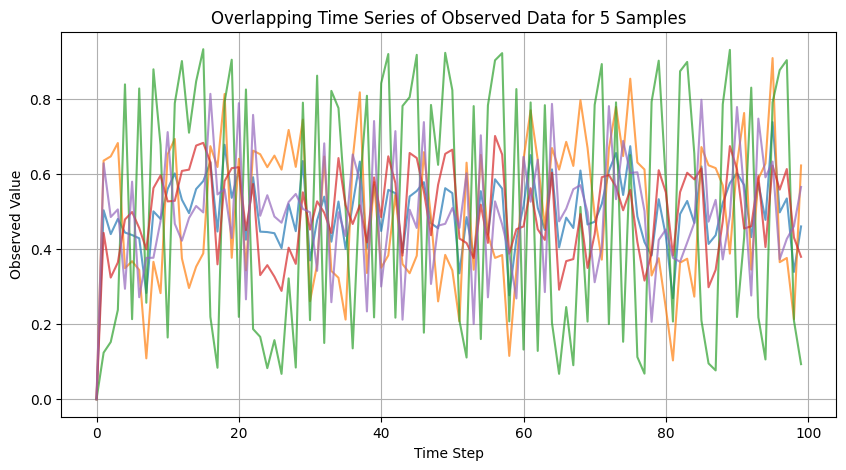

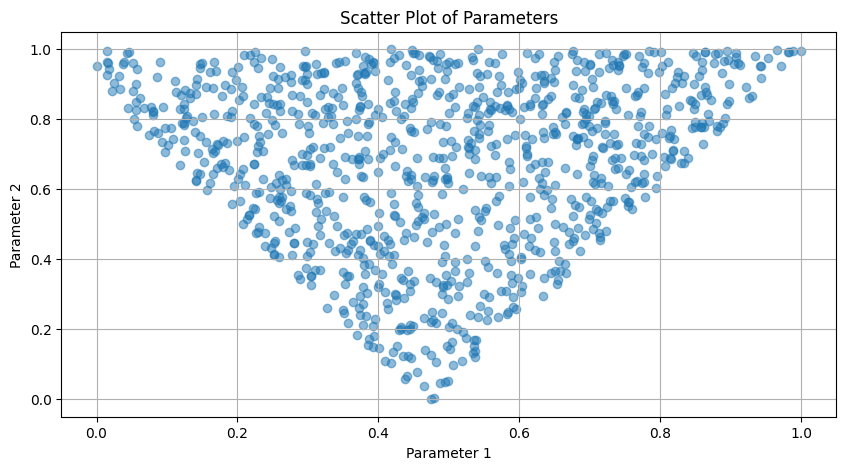

In [16]:
ma2.plot_observation(train_data_norm, 5)
ma2.plot_prior(train_theta_norm)

# Define the CVAE Network

In [17]:
input_dim = 2
latent_dim = 10
conditional_dim = 100
encoder_hidden_dims = [200, 200]
decoder_hidden_dims = [200,200]


network = CVAE(input_dim=input_dim, latent_dim=latent_dim, output_dim=input_dim,
        conditional_dim=conditional_dim, encoder_hidden_dims=encoder_hidden_dims,
        decoder_hidden_dims=decoder_hidden_dims)


optimizer = optim.AdamW(network.parameters(), lr=1e-3)

train_dataset = TensorDataset(train_data_norm, train_theta_norm)
train_loader = DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)

#print(network)

In [18]:
network.train_model(train_loader=train_loader, optimizer=optimizer, epochs=30, 
                    device=device, theta_normalizer=theta_normalizer,
                      data_normalizer=data_normalizer, forward_model= ma2.simulator)

Using CPU
Epoch 1/30, Beta: 0.0, Total Loss: 744.3889, Recon Loss: 744.3889, Misfit Loss: 0.0000, KL Div: 60.3775
Epoch 2/30, Beta: 0.1, Total Loss: 497.0493, Recon Loss: 486.5923, Misfit Loss: 0.0000, KL Div: 104.5691
Epoch 3/30, Beta: 0.2, Total Loss: 317.4305, Recon Loss: 297.0164, Misfit Loss: 0.0000, KL Div: 102.0705
Epoch 4/30, Beta: 0.3, Total Loss: 181.0317, Recon Loss: 158.5527, Misfit Loss: 0.0000, KL Div: 74.9301
Epoch 5/30, Beta: 0.4, Total Loss: 104.9687, Recon Loss: 86.8339, Misfit Loss: 0.0000, KL Div: 45.3368
Epoch 6/30, Beta: 0.5, Total Loss: 111.1586, Recon Loss: 99.2923, Misfit Loss: 0.0000, KL Div: 23.7326
Epoch 7/30, Beta: 0.6, Total Loss: 150.5832, Recon Loss: 142.9220, Misfit Loss: 0.0000, KL Div: 12.7686
Epoch 8/30, Beta: 0.7, Total Loss: 150.7043, Recon Loss: 143.1469, Misfit Loss: 0.0000, KL Div: 10.7963
Epoch 9/30, Beta: 0.8, Total Loss: 120.7126, Recon Loss: 110.4618, Misfit Loss: 0.0000, KL Div: 12.8135
Epoch 10/30, Beta: 0.9, Total Loss: 83.3072, Recon Los

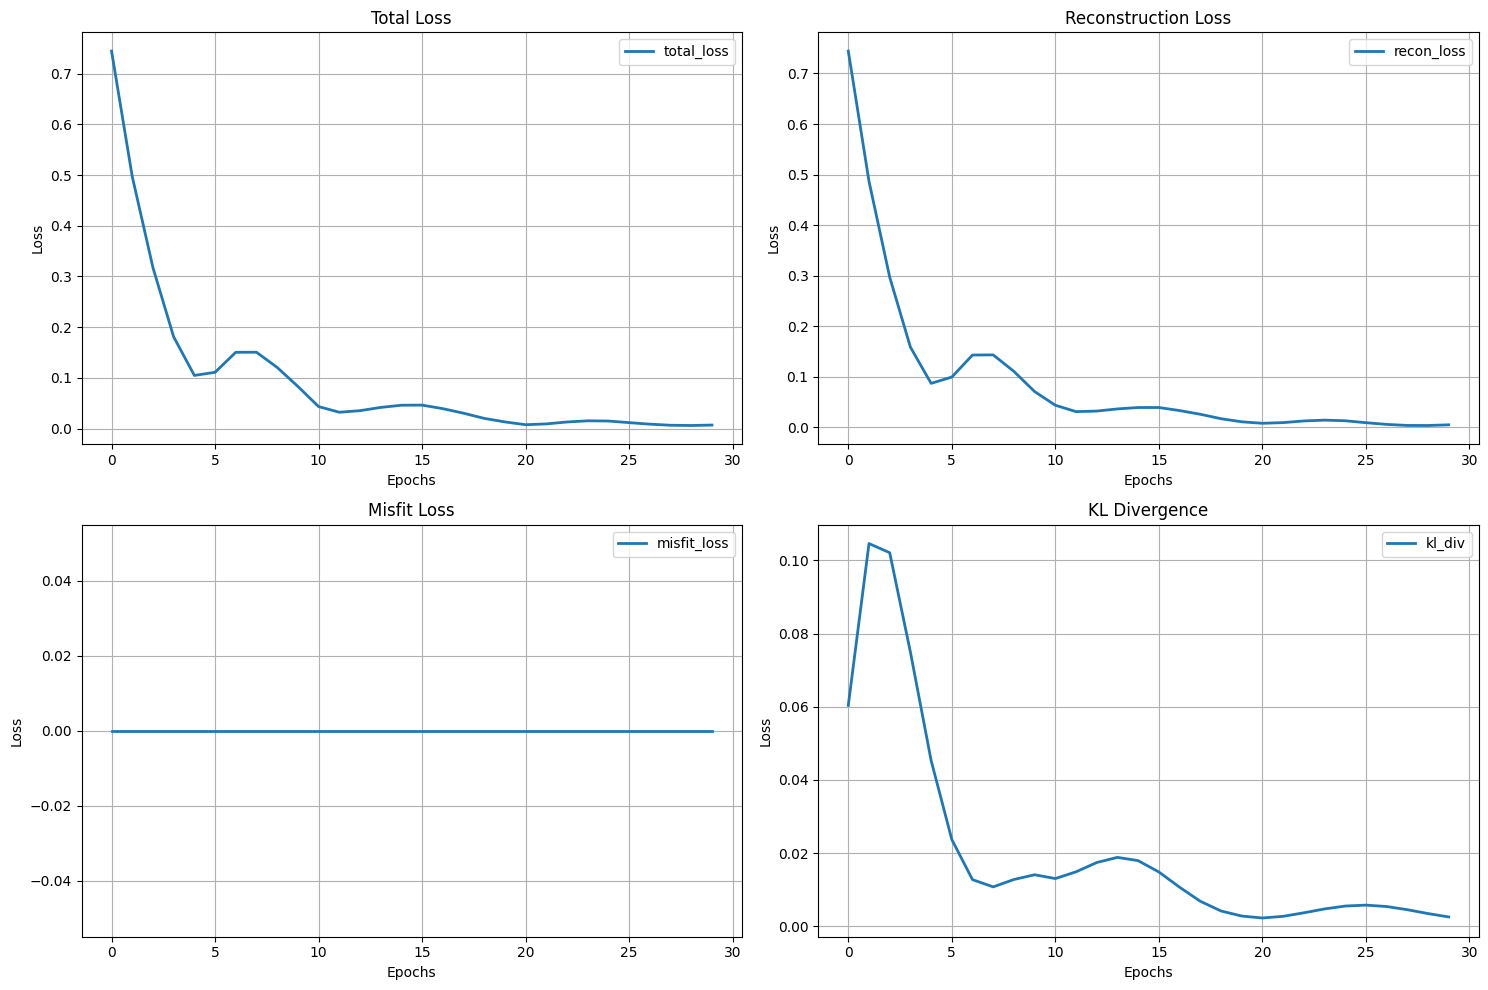

In [19]:
network.plot_loss()

# Inference

In [20]:
post = network.get_posterior(observed_data= observed_data, num_samples=10000)
post = theta_normalizer.inverse_transform(post)


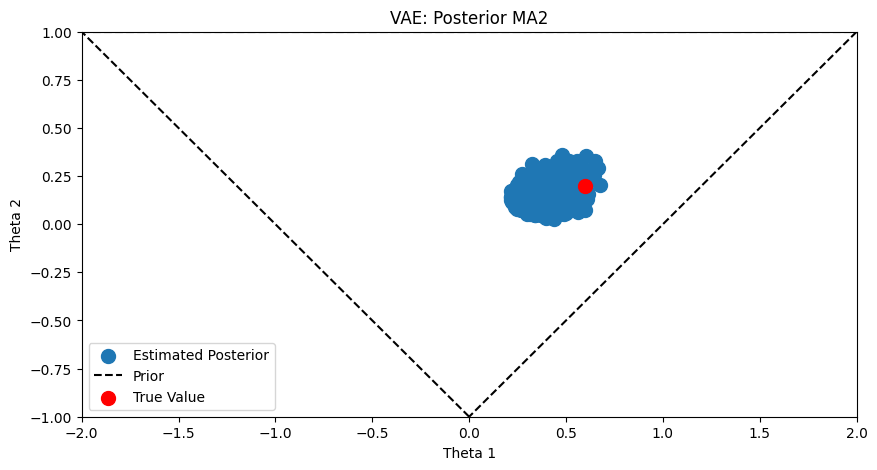

In [21]:
ma2.plot_posterior(post)

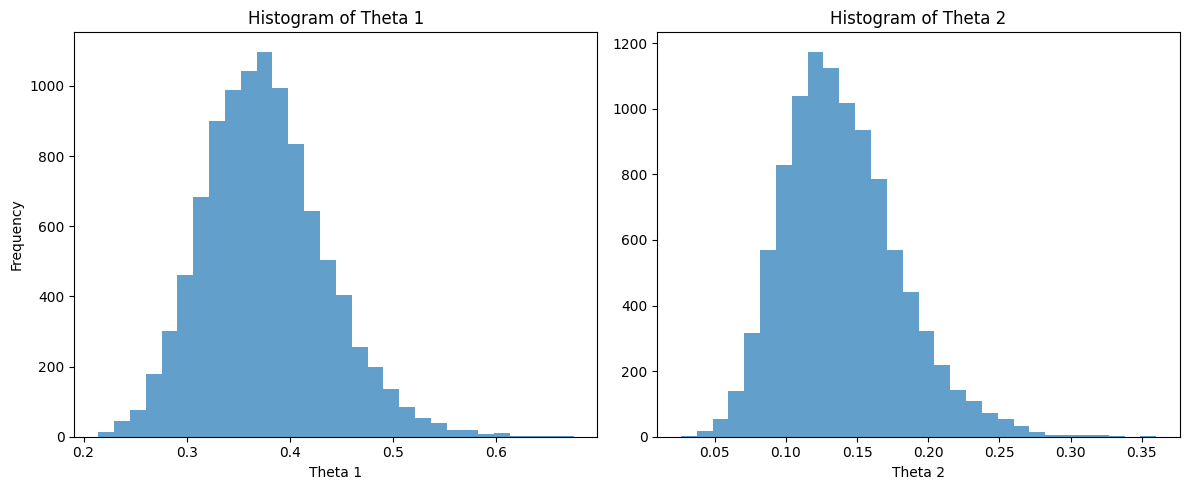

In [22]:
ma2.posterior_hist(post)